# Customer Churn Prediction Using Machine Learning

Goal: Predict whether a customer will churn (Exited column: 1 = churned, 0 = stayed).

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Load Dataset
df = pd.read_csv("churn.csv")

In [3]:
# Shape of dataset
print(f"\n Dataset Shape: {df.shape[0]} rows & {df.shape[1]} columns")


 Dataset Shape: 10000 rows & 14 columns


In [4]:
# Preview first 5 rows
print("First 5 Rows of the Dataset:")
display(df.head())

First 5 Rows of the Dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Dataset info
print("\n Dataset Info:")
df.info()


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Check for missing values
print("\n Missing Values:")
print(df.isnull().sum())


 Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [7]:
# Data types of each column
print(" Data Types:")
print(df.dtypes)

 Data Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [8]:
# Summary statistics for numerical features
print(" Summary Statistics (Numerical):")
print(df.describe().T)

 Summary Statistics (Numerical):
                   count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000

In [9]:
# Value counts for categorical columns
print("\n🔹 Categorical Value Counts:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col}:\n", df[col].value_counts())


🔹 Categorical Value Counts:

Surname:
 Surname
Smith        32
Scott        29
Martin       29
Walker       28
Brown        26
             ..
Hull          1
Sturdee       1
Flannagan     1
Dwyer         1
Corby         1
Name: count, Length: 2932, dtype: int64

Geography:
 Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender:
 Gender
Male      5457
Female    4543
Name: count, dtype: int64


# Exploratory Data Analysis

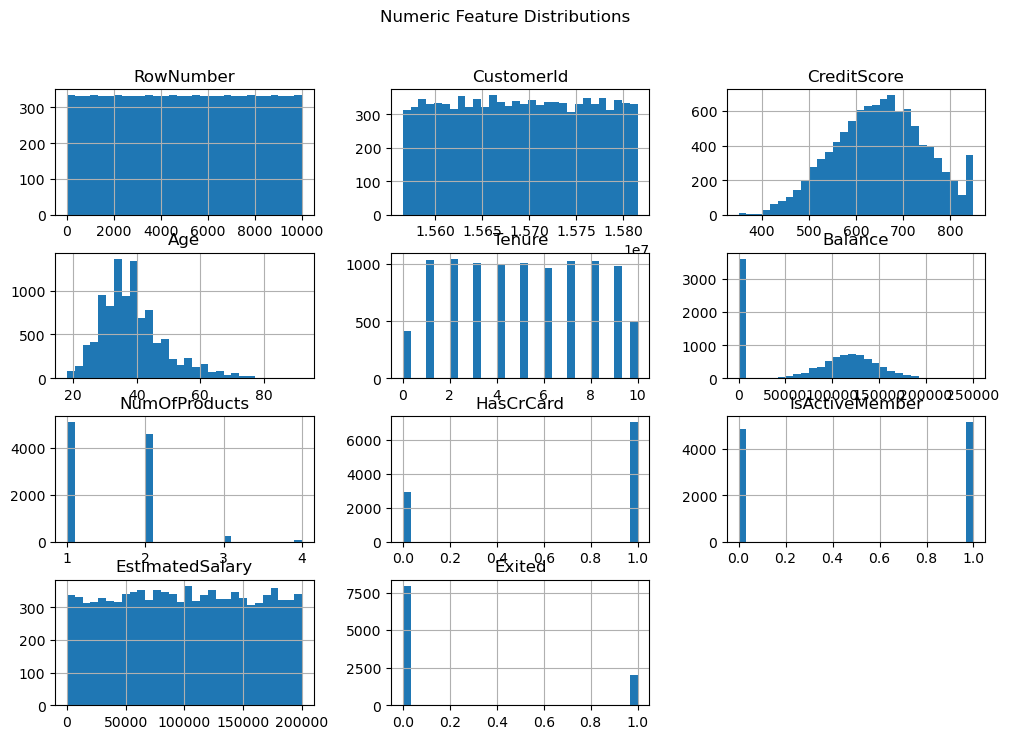

In [10]:
# Numerical columns distribution
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

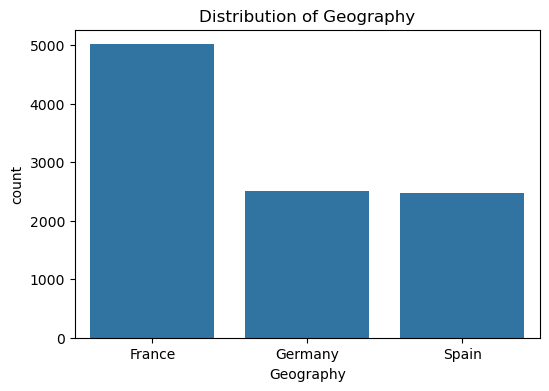

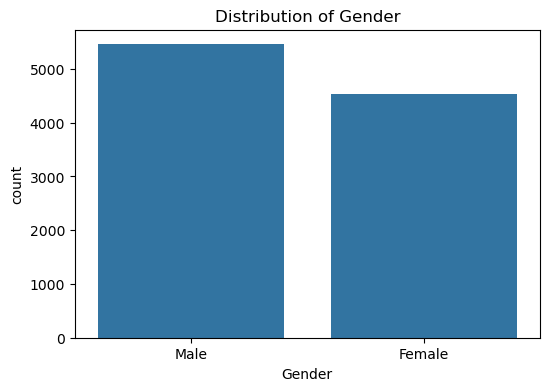

In [11]:
# Get all categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Remove 'Surname' from categorical columns
categorical_cols = [col for col in categorical_cols if col.lower() != 'surname']

# Plot distributions
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()

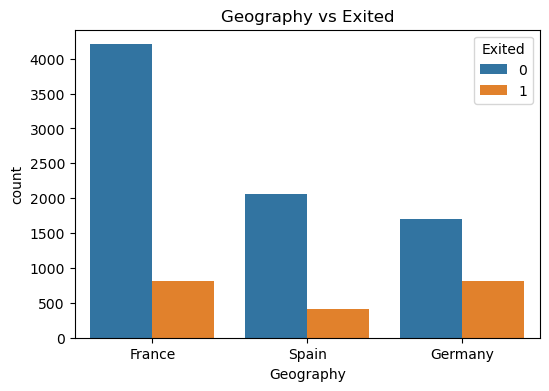

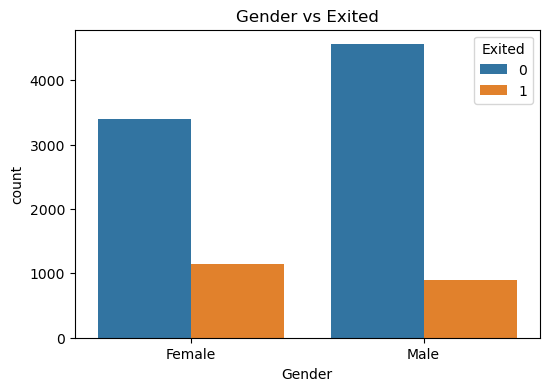

In [12]:
# Relationship between categorical features and target
target_col = 'Exited' 
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue=target_col, data=df)
    plt.title(f"{col} vs {target_col}")
    plt.legend(title=target_col)
    plt.show()

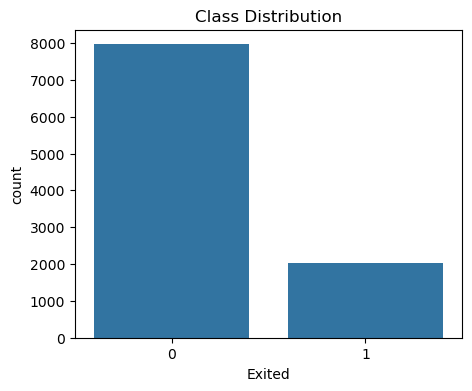


🔹 Class Distribution:
 Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [13]:
# Class distribution (target variable)
target_col = 'Exited'  
plt.figure(figsize=(5, 4))
sns.countplot(x=target_col, data=df)
plt.title("Class Distribution")
plt.show()

# Numeric distribution
print("\n🔹 Class Distribution:\n", df[target_col].value_counts(normalize=True))

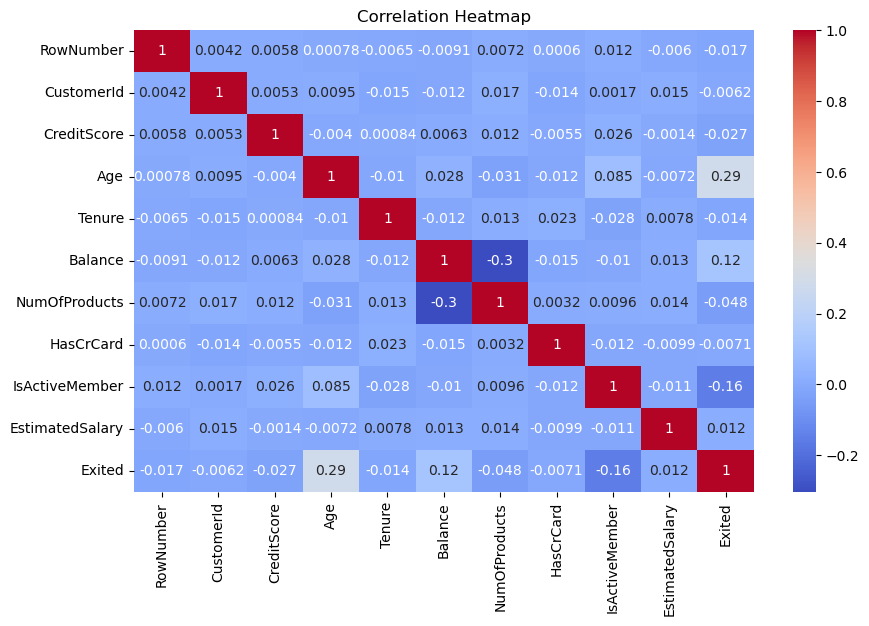

In [14]:
# Correlation heatmap (numeric features)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Data Cleaning

In [15]:
# Remove Duplicates
df.drop_duplicates(inplace=True)

In [16]:
# Standardize Category Labels
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [17]:
# Convert Text-Based Numbers to Numeric (if applicable)

def text_to_num(x):
    try:
        # Remove non-numeric characters
        return pd.to_numeric(str(x).replace(',', '').replace('sqft', '').strip(), errors='coerce')
    except:
        return np.nan

for col in cat_cols:
    if df[col].str.contains(r'\d').any():  # If column contains numbers in text
        df[col] = df[col].apply(text_to_num)

In [18]:
# Drop ID-like columns that don't help prediction
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [19]:
print(" Data Cleaning Complete")
print("Shape:", df.shape)

 Data Cleaning Complete
Shape: (10000, 11)


In [20]:
print("Remaining Missing Values:\n", df.isnull().sum())

Remaining Missing Values:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [21]:
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,france,female,42,2,0.00,1,1,1,101348.88,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1
3,699,france,female,39,1,0.00,2,0,0,93826.63,0
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0


# Feature Engineering

In [22]:
# target column is:
target_col = 'Exited'

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Group rare categories before encoding (optional)
def group_rare(series, threshold=0.01):
    freq = series.value_counts(normalize=True)
    rare_labels = freq[freq < threshold].index
    return series.apply(lambda x: 'Other' if x in rare_labels else x)

for col in cat_cols:
    df[col] = group_rare(df[col])

# Apply Target Encoding
te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df[target_col])

print(df.shape)
df.head()

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57,1
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0


# Outlier Handling

In [23]:
# Detect a likely target column (edit if needed)
target_col = (
    'Exited' if 'Exited' in df.columns else
    None
)

# Numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target column from numeric list (if present & numeric)
if target_col is not None and target_col in num_cols:
    num_cols.remove(target_col)

Boxplots 1–4 of 10


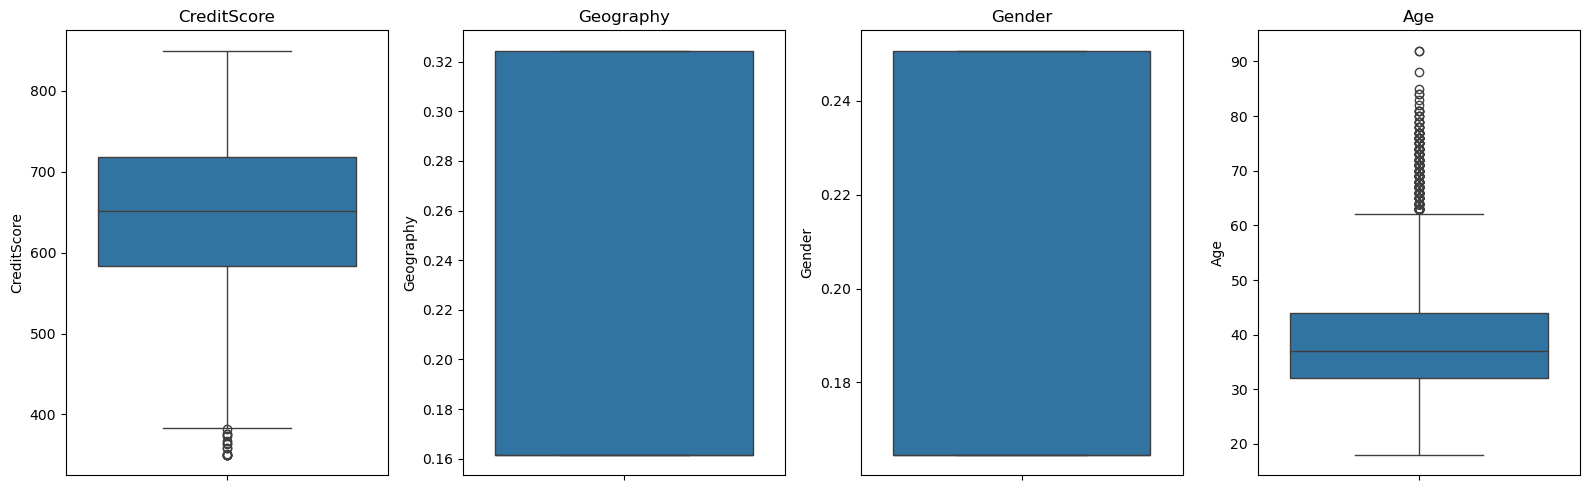

Boxplots 5–8 of 10


In [ ]:
# Plot in steps of 4 per figure
n_per_fig = 4
total = len(num_cols)

for start in range(0, total, n_per_fig):
    cols_chunk = num_cols[start:start + n_per_fig]
    n = len(cols_chunk)

    print(f"Boxplots {start + 1}–{start + n} of {total}")
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 5))  # ~4 inches per subplot
    if n == 1:
        axes = [axes]  # make iterable

    for ax, col in zip(axes, cols_chunk):
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")  # cleaner look

    plt.tight_layout()
    plt.show()


In [ ]:
# Remove outliers using IQR method
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Condition to filter rows that are NOT outliers
condition = ~(
    (df[num_cols] < (Q1 - 1.5 * IQR)) |
    (df[num_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

# Filter DataFrame
df= df[condition].reset_index(drop=True)

print(f"After removing outliers: {df.shape}")

# Train-Test Split

In [ ]:
# Define target column
target_col = 'Exited'  

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
# Train-test split (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserves class distribution
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Target distribution in train set:")
print(y_train.value_counts(normalize=True))
print("Target distribution in test set:")
print(y_test.value_counts(normalize=True))

# Feature Scaling

In [ ]:
# Select numeric columns from training data
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# StandardScaler (mean=0, variance=1)
scaler_standard = StandardScaler()
X_train_standard = X_train.copy()
X_test_standard = X_test.copy()

X_train_standard[num_cols] = scaler_standard.fit_transform(X_train[num_cols])
X_test_standard[num_cols] = scaler_standard.transform(X_test[num_cols])

print("Scaling applied successfully.")


# Model Training & Evaluation

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "ROC-AUC": round(auc, 4)
  })

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
print("\nModel Comparison:\n", results_df)

In [ ]:
# Plot Comparison

plt.figure(figsize=(8,5))
sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (ROC-AUC)")
plt.show()

# Random Forest Hyperparameter Tuning

In [ ]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

In [ ]:
from random import randint

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt']
}
rf_random = RandomizedSearchCV(rf, rf_param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Create DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the first few rows
print(results_df.head())

# Conclusion

* Model Performance:

Random Forest achieved the highest accuracy (0.8595) and ROC-AUC (0.8506), indicating strong overall classification performance.

XGBoost performed comparably with a slightly higher F1-score (0.5425) but lower ROC-AUC (0.8289), suggesting better balance on positive class detection.

Logistic Regression showed lower performance across all metrics, indicating that a linear model may not capture complex patterns in the data.

* Insights:

Ensemble methods (Random Forest and XGBoost) handle feature interactions and non-linearities better than simple linear models.

F1-score differences indicate that class imbalance may affect some models more than others.

* Recommendation:

Random Forest is recommended as the primary model due to high accuracy and AUC.

XGBoost can be considered if improving F1-score is prioritized.

Logistic Regression can serve as a baseline or for interpretability purposes.